# Relationship between fixed effects, random effects, GLS, and penalized regression; confounding; model misspecification

In [21]:
library(data.table)
library(ggplot2)
library(lme4)
library(parallel)
library(penalized)
library(xtable)

theme_set(theme_bw())

Loading required package: survival
Welcome to penalized. For extended examples, see vignette("penalized").


## Prepare Data

In [2]:
literacy.covariates.data <- data.table(subject=c(1:91))
literacy.covariates.data[,base.age:=1 + 0.1*(subject - 1)]
literacy.covariates.data[,`0`:=base.age]
literacy.covariates.data[,`1`:=`0` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data[,`2`:=`1` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data[,subject:=factor(subject)]
literacy.covariates.data <- melt(literacy.covariates.data, id.vars=c('subject', 'base.age'),
                                 value.name='total.age', variable.name='follow.per')
literacy.covariates.data[,follow.per:=factor(as.numeric(follow.per) - 1, ordered=TRUE)]
setkey(literacy.covariates.data, subject, follow.per)
literacy.covariates.data[,delta.age:=total.age - base.age]
head(literacy.covariates.data)

subject,base.age,follow.per,total.age,delta.age
1,1.0,0,1.0000,0.0000
1,1.0,1,4.6100,3.6100
1,1.0,2,8.2200,7.2200
2,1.1,0,1.1000,0.0000
2,1.1,1,4.6721,3.5721
2,1.1,2,8.2442,7.1442


## Response

In [3]:
make.base.literacy <- function(base.age) {
    (10 - base.age)^2
}

make.response <- function(covariates, variance=100) {
    make.base.literacy(covariates$base.age) +
    covariates$delta.age +
    rnorm(n=nrow(covariates), sd=sqrt(variance))
}

## Visualization

png 
  2

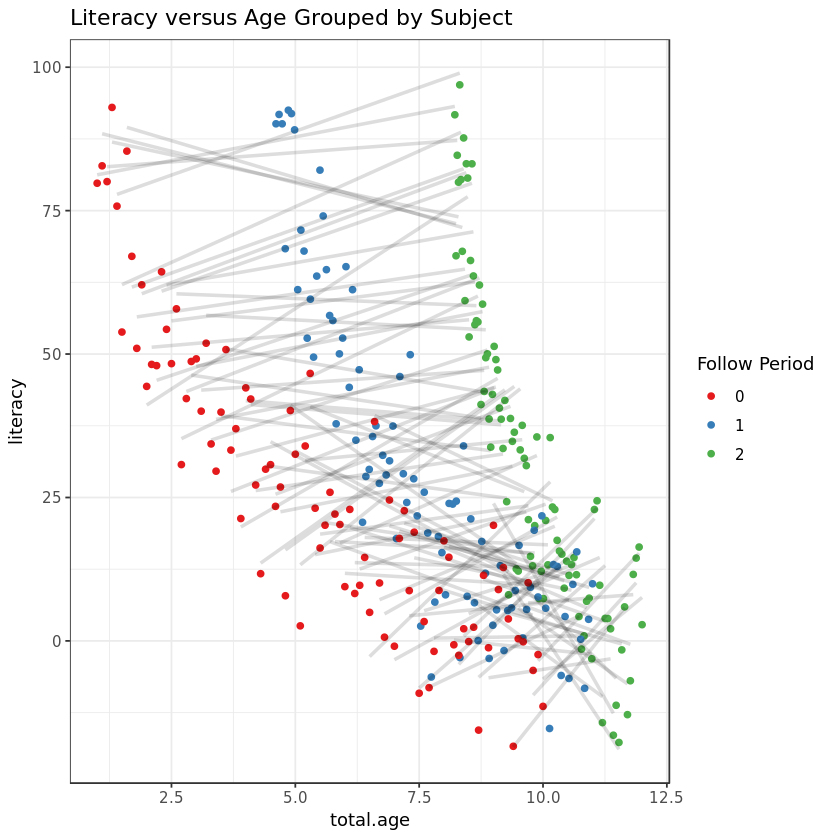

In [4]:
set.seed(2021)
literacy.data <- copy(literacy.covariates.data)
literacy.data[,literacy:=make.response(literacy.data)]

p <- ggplot(literacy.data, aes(x=total.age, y=literacy)) +
  geom_point(aes(color=follow.per)) +
  scale_color_brewer('Follow Period', palette='Set1') + 
  geom_smooth(aes(group=subject), method='lm', se=FALSE, color='#00000022') +
  ggtitle('Literacy versus Age Grouped by Subject')

pdf('literacy_versus_age.pdf', width=6, height=3.75)
p
dev.off()
p

png 
  2

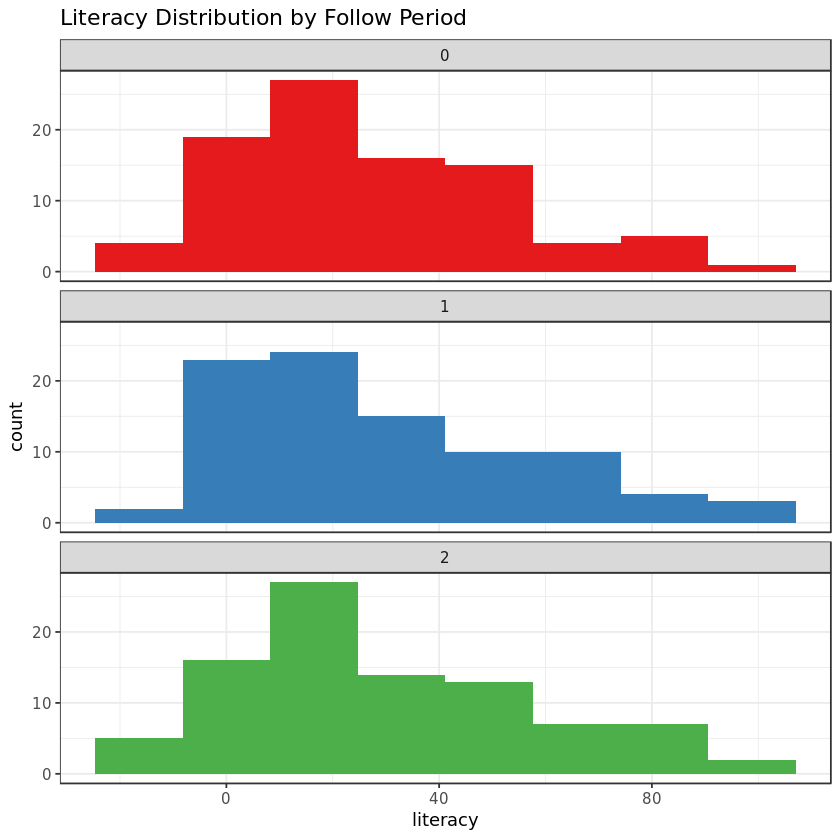

In [5]:
p <- ggplot(literacy.data, aes(x=literacy, fill=follow.per)) +
  geom_histogram(bins=8) +
  scale_fill_brewer('Follow Period', palette='Set1', guide=FALSE) +
  facet_wrap(~follow.per, ncol=1) +
  ggtitle('Literacy Distribution by Follow Period')

pdf('literacy_by_follow_period.pdf', width=6, height=6)
p
dev.off()
p

## Simulation Study: Random versus Fixed Effect Intercept

In [6]:
lmer.simulation.samples <- do.call(rbind, mclapply(replicate(4096, literacy.covariates.data, simplify=FALSE), function(covariates) {
    literacy <- make.response(covariates)
    model <- lmer(literacy ~ delta.age + (1|subject), data=covariates, REML=TRUE)
    var.corr <- VarCorr(model)
    data.frame(
        delta.age=fixef(model)[['delta.age']],
        delta.age.std.error=summary(model)$coefficients['delta.age', 'Std. Error'],
        sigma=attributes(var.corr)$sc,
        sigma.random=attributes(var.corr$subject)$stddev[['(Intercept)']])
}, mc.cores=4))

In [7]:
lm.simulation.samples <- do.call(rbind, mclapply(replicate(4096, literacy.covariates.data, simplify=FALSE), function(covariates) {
    literacy <- make.response(covariates)
    model <- lm(literacy ~ subject + delta.age, data=covariates)
    model.summary <- summary(model)
    data.frame(
        delta.age=model$coefficients[['delta.age']],
        delta.age.std.error=model.summary$coefficients['delta.age', 'Std. Error'],
        sigma=model.summary$sigma)
    
}, mc.cores=4))

In [8]:
summarize.simulation <- function(data) {
    l <- list(
        `$\\mathbb{E}\\left[\\hat{\\beta}_L\\right]$`=mean(data$delta.age),
        `$\\mathbb{E}\\left[\\hat{\\sigma}_{\\hat{\\beta}_L}\\right]$`=mean(data$delta.age.std.error),
        `Sample $\\hat{\\sigma}_{\\hat{\\beta}_L}$`=sd(data$delta.age),
        `$\\mathbb{E}\\left[\\hat{\\sigma}\\right]$`=mean(data$sigma))
    l[['$\\mathbb{E}\\left[\\hat{\\sigma}_{\\gamma}\\right]$']] <- if ('sigma.random' %in% names(data)) {
        mean(data$sigma.random)
    } else {
        NA
    }
    l
}

In [9]:
simulation.comparison <- as.data.frame(rbind(
    data.table(lmer.simulation.samples)[,summarize.simulation(.SD)],
    data.table(lm.simulation.samples)[,summarize.simulation(.SD)]))
row.names(simulation.comparison) <- c('Random Effects Intercept', 'Fixed Effects Intercept')
simulation.comparison

,$\mathbb{E}\left[\hat{\beta}_L\right]$,$\mathbb{E}\left[\hat{\sigma}_{\hat{\beta}_L}\right]$,Sample $\hat{\sigma}_{\hat{\beta}_L}$,$\mathbb{E}\left[\hat{\sigma}\right]$,$\mathbb{E}\left[\hat{\sigma}_{\gamma}\right]$
Random Effects Intercept,1.2762289,0.3208256,0.3284886,10.008001,24.35076
Fixed Effects Intercept,0.9984203,0.3214776,0.3239654,9.983993,NA


In [10]:
print(xtable(simulation.comparison,
             caption=paste('\\small Results of a simulation study comparing modeling the ',
                           'subject-specific intercepts as a random effect or fixed effect.',
                           'Parameter estimates were averaged over simulations. Standard errors',
                           'for $\\hat{\\beta_L}$ are calculated two ways:',
                           '(1) assuming the model is correct',
                           '($\\mathbb{E}\\left[\\hat{\\sigma}_{\\hat{\\beta}_L}\\right]$),',
                           'and (2) using the $\\hat{\\beta_L}$ samples',
                           '(Sample $\\hat{\\sigma}_{\\hat{\\beta}_L}$).'),
             label='tab:simulation_comparison',
             digits=c(0, 6, 6, 6, 6, 6)),
      booktabs=TRUE,
      sanitize.colnames.function=identity,
      sanitize.rownames.function=identity,
      size='small',
      file='simulation_comparison.tex')

## $\sigma_\gamma$ Calculation

In [6]:
base.literacy <- make.base.literacy(literacy.covariates.data[follow.per==0]$base.age)
variance.random.intercept <- mean((base.literacy - mean(base.literacy))^2)
sqrt(variance.random.intercept)

[1] 24.43306

## Expected $\hat{\beta}$

### GLS

In [136]:
expect.beta.hat.gls <- function(residual.variance) {
    subject.covariance.inv <- chol2inv(chol(
        as.matrix(nlme::pdCompSymm(variance.random.intercept + diag(3)*residual.variance))))
    projected.data <- lapply(levels(literacy.covariates.data$subject), function(i) {
        data <- literacy.covariates.data[J(i)]
        X <- cbind(1, data$delta.age)
        tX <- t(X)
        list(X=tX %*% subject.covariance.inv %*% X,
             y=tX %*% subject.covariance.inv %*% make.response(data, 0))
    })    
    projected.X <- Reduce(
        `+`, lapply(projected.data, function(projection) { projection$X }))
    projected.y <- Reduce(
        `+`, lapply(projected.data, function(projection) { projection$y }))    
    beta.hat <- as.vector(chol2inv(chol(projected.X)) %*% projected.y)
    names(beta.hat) <- c('(Intercept)', 'delta.age')        
    beta.hat
}

In [137]:
expect.beta.hat.gls(10)
expect.beta.hat.gls(100)
expect.beta.hat.gls(1000)

(Intercept)   delta.age 
  27.087296    1.028876

(Intercept)   delta.age 
  26.557434    1.272883

(Intercept)   delta.age 
   23.32660     2.76072

### Ridge Regression

In [35]:
expect.beta.hat.ridge <- function(residual.variance) {
    X <- cbind(1, model.matrix(~ 0 + delta.age + subject, literacy.covariates.data))
    y <- make.response(literacy.covariates.data, 0)
    # Penalize only random effects.
    Q <- diag(ncol(X))
    Q[1, 1] <- 0
    Q[2, 2] <- 0
    # Estimate beta
    tX <- t(X)    
    beta.hat <- as.vector(chol2inv(chol(tX %*% X + residual.variance/variance.random.intercept*Q)) %*% tX %*% y)
    names(beta.hat) <- colnames(X)
    names(beta.hat)[1] <- '(Intercept)'
    beta.hat
}

In [73]:
expect.beta.hat.ridge(10)['delta.age']
expect.beta.hat.ridge(100)['delta.age']
expect.beta.hat.ridge(1000)['delta.age']

delta.age 
 1.028876

delta.age 
 1.272883

delta.age 
  2.76072

### Penalized Regression

In [43]:
expect.beta.hat.penalized <- function(residual.variance) {
    coef(penalized(make.response(literacy.covariates.data, 0),
                   unpenalized=~delta.age,
                   penalized=~subject,                       
                   data=literacy.covariates.data,
                   lambda2=residual.variance/variance.random.intercept))
}

In [63]:
expect.beta.hat.penalized(1)['delta.age']
expect.beta.hat.penalized(10)['delta.age']
expect.beta.hat.penalized(100)['delta.age']
expect.beta.hat.penalized(1000)['delta.age']

delta.age 
 1.002905

delta.age 
 1.028876

delta.age 
 1.272883

delta.age 
  2.76072

In [133]:
mean(base.literacy - expect.beta.hat.penalized(10)[['(Intercept)']])

[1] 0.06270432

In [68]:
expect.beta.hat.penalized(100)

(Intercept)   delta.age    subject1    subject2    subject3    subject4 
 26.5574340   1.2728832  50.6304006  48.9448587  47.2782074  45.6304468 
   subject5    subject6    subject7    subject8    subject9   subject10 
 44.0015768  42.3915974  40.8005087  39.2283105  37.6750030  36.1405861 
  subject11   subject12   subject13   subject14   subject15   subject16 
 34.6250599  33.1284242  31.6506792  30.1918248  28.7518611  27.3307879 
  subject17   subject18   subject19   subject20   subject21   subject22 
 25.9286054  24.5453135  23.1809123  21.8354016  20.5087816  19.2010522 
  subject23   subject24   subject25   subject26   subject27   subject28 
 17.9122135  16.6422653  15.3912078  14.1590410  12.9457647  11.7513791 
  subject29   subject30   subject31   subject32   subject33   subject34 
 10.5758840   9.4192797   8.2815659   7.1627428   6.0628102   4.9817683 
  subject35   subject36   subject37   subject38   subject39   subject40 
  3.9196171   2.8763564   1.8519864   0.8465070  -0.1400817  -1.1077799 
  subject41   subject42   subject43   subject44   subject45   subject46 
 -2.0565874  -2.9865043  -3.8975305  -4.7896662  -5.6629112  -6.5172656 
  subject47   subject48   subject49   subject50   subject51   subject52 
 -7.3527293  -8.1693025  -8.9669850  -9.7457769 -10.5056781 -11.2466888 
  subject53   subject54   subject55   subject56   subject57   subject58 
-11.9688088 -12.6720382 -13.3563770 -14.0218251 -14.6683826 -15.2960495 
  subject59   subject60   subject61   subject62   subject63   subject64 
-15.9048258 -16.4947114 -17.0657064 -17.6178108 -18.1510246 -18.6653477 
  subject65   subject66   subject67   subject68   subject69   subject70 
-19.1607803 -19.6373222 -20.0949734 -20.5337341 -20.9536041 -21.3545835 
  subject71   subject72   subject73   subject74   subject75   subject76 
-21.7366722 -22.0998704 -22.4441779 -22.7695948 -23.0761211 -23.3637567 
  subject77   subject78   subject79   subject80   subject81   subject82 
-23.6325017 -23.8823561 -24.1133199 -24.3253931 -24.5185756 -24.6928675 
  subject83   subject84   subject85   subject86   subject87   subject88 
-24.8482687 -24.9847794 -25.1023994 -25.2011288 -25.2809676 -25.3419157 
  subject89   subject90   subject91 
-25.3839732 -25.4071401 -25.4114164

In [138]:
expect.beta.hat.penalized(1000)

(Intercept)   delta.age    subject1    subject2    subject3    subject4 
 23.3265968   2.7607199  32.9300215  31.8242076  30.7310017  29.6504037 
   subject5    subject6    subject7    subject8    subject9   subject10 
 28.5824137  27.5270316  26.4842575  25.4540913  24.4365330  23.4315827 
  subject11   subject12   subject13   subject14   subject15   subject16 
 22.4392403  21.4595058  20.4923793  19.5378608  18.5959502  17.6666475 
  subject17   subject18   subject19   subject20   subject21   subject22 
 16.7499528  15.8458660  14.9543871  14.0755162  13.2092532  12.3555982 
  subject23   subject24   subject25   subject26   subject27   subject28 
 11.5145511  10.6861120   9.8702808   9.0670575   8.2764422   7.4984348 
  subject29   subject30   subject31   subject32   subject33   subject34 
  6.7330354   5.9802439   5.2400604   4.5124848   3.7975171   3.0951574 
  subject35   subject36   subject37   subject38   subject39   subject40 
  2.4054056   1.7282617   1.0637258   0.4117979  -0.2275221  -0.8542342 
  subject41   subject42   subject43   subject44   subject45   subject46 
 -1.4683383  -2.0698345  -2.6587228  -3.2350031  -3.7986755  -4.3497399 
  subject47   subject48   subject49   subject50   subject51   subject52 
 -4.8881964  -5.4140449  -5.9272855  -6.4279182  -6.9159429  -7.3913597 
  subject53   subject54   subject55   subject56   subject57   subject58 
 -7.8541685  -8.3043694  -8.7419623  -9.1669473  -9.5793244  -9.9790935 
  subject59   subject60   subject61   subject62   subject63   subject64 
-10.3662547 -10.7408079 -11.1027532 -11.4520906 -11.7888200 -12.1129415 
  subject65   subject66   subject67   subject68   subject69   subject70 
-12.4244550 -12.7233606 -13.0096583 -13.2833480 -13.5444297 -13.7929036 
  subject71   subject72   subject73   subject74   subject75   subject76 
-14.0287694 -14.2520274 -14.4626774 -14.6607194 -14.8461536 -15.0189797 
  subject77   subject78   subject79   subject80   subject81   subject82 
-15.1791980 -15.3268083 -15.4618106 -15.5842050 -15.6939915 -15.7911700 
  subject83   subject84   subject85   subject86   subject87   subject88 
-15.8757406 -15.9477032 -16.0070579 -16.0538047 -16.0879435 -16.1094744 
  subject89   subject90   subject91 
-16.1183973 -16.1147123 -16.0984193